# Классификация текстов

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import random
random.seed(1228)

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = pd.read_csv("articles_lemmatized_noSW.csv", index_col="Unnamed: 0")
data = data[data.topic.isin(("Культура", "Общество", "Политика", "Экономика", "Спорт"))] 
train_corpus = pd.DataFrame(columns=data.columns)
test_corpus = pd.DataFrame(columns=data.columns)

for topic in data.topic.unique():
    corpus_sample = data[data.topic==topic].sample(110)
    train_corpus = train_corpus.append(corpus_sample.iloc[:100, :])
    test_corpus = test_corpus.append(corpus_sample.iloc[100:, :])

In [3]:
data.head()

,headline,body,topic
44908,Российские кинокартины не будут претендовать н...,номинация хороший фильм иностранный язык попад...,Культура
30711,Владимир Гусев: кризис ударил и по мне,обозреватель известие пообщаться директор русс...,Культура
15990,"«Аутисты — такие же зрители, как и остальные»",первый россия кинозал человек расстройство аут...,Культура
18281,Вахтанговцы вновь покажут «Евгения Онегина» в ...,режиссер московский театр римас туминас получа...,Культура
4666,"Наталья Крачковская хотела, чтобы в последний ...",прощание знаменитый киноактриса состояться мар...,Культура


In [4]:
TEXT_LENGTH = 1800
VOCABULARY_SIZE = 250000
EMBEDDING_DIM = 100
DIMS = 250
MAX_FEATURES = 5000
batch_size = 32

nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 10

## Сеть прямого распространения

In [5]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_corpus.body)
tokenizer

In [6]:
sequences = tokenizer.texts_to_sequences(train_corpus.body)
X_train = tokenizer.sequences_to_matrix(sequences, mode='count')
sequences = tokenizer.texts_to_sequences(test_corpus.body)
X_test = tokenizer.sequences_to_matrix(sequences, mode='count')

In [7]:
print('First seq:', sequences[0])
print('First doc:',X_train[0])

First seq: [280, 215, 3141, 23, 662, 2470, 1154, 29, 3184, 331, 4180, 1041, 178, 111, 215, 152, 1041, 87, 682, 950, 367, 228, 4, 122, 132, 1561, 763, 2470, 682, 486, 1238, 5, 510, 1786, 2053, 122, 670, 906, 886, 1447, 949, 122, 132, 1561, 2470, 21, 3294, 690, 3989, 2256, 1278, 210, 171, 7, 1793, 217, 1598, 762, 2754, 1370, 1793, 3989, 623, 200, 1003, 30, 1112, 3062, 4754, 474, 4213, 122, 132, 1370, 1549, 119, 1933, 4208, 134, 2273, 57, 33, 2470, 953, 86, 125, 3468, 1035, 122, 1561, 2055, 165, 1720, 364, 697, 3024, 416, 4180, 293, 367, 448, 1216, 510, 670, 13, 18, 367, 17, 1168, 522, 559, 3066, 1942, 3, 2470, 509, 132, 122, 414, 37, 408, 1561, 43, 12, 2088, 957, 2504, 367, 1900, 4209, 1439, 3453, 2470, 951, 160, 3453, 250, 1222, 462, 411, 230, 869, 593, 71, 4118, 430, 3023, 95, 1156, 4184, 1089, 372, 1222, 3453, 522, 157, 560, 348, 13, 122, 2097, 2055, 119, 1524, 952, 839, 575, 331, 2893, 372, 240, 1761, 164, 675, 2471, 339, 627, 378, 4508, 331, 1710, 3156, 150, 122, 2470, 627, 1373, 23

In [8]:
le = LabelEncoder()
le.fit(train_corpus.topic.unique())
y_train = np_utils.to_categorical(le.transform(train_corpus.topic), 5)
y_test = np_utils.to_categorical(le.transform(test_corpus.topic), 5)
y_true = le.transform(test_corpus.topic)
print(y_train[0])

[1. 0. 0. 0. 0.]


In [9]:
model = Sequential()
model.add(Dense(756, input_shape=(MAX_FEATURES,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 [==============================] - 1s 3ms/step - loss: 0.9810 - acc: 0.6533 - val_loss: 0.6645 - val_acc: 0.7400
Epoch 2/10
450/450 [==============================] - 0s 187us/step - loss: 0.0806 - acc: 0.9911 - val_loss: 0.6934 - val_acc: 0.7800
Epoch 3/10
450/450 [==============================] - 0s 181us/step - loss: 0.0188 - acc: 1.0000 - val_loss: 0.6513 - val_acc: 0.7800
Epoch 4/10
450/450 [==============================] - 0s 180us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.6593 - val_acc: 0.8200
Epoch 5/10
450/450 [==============================] - 0s 187us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.6823 - val_acc: 0.8000
Epoch 6/10
450/450 [==============================] - 0s 188us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.7002 - val_acc: 0.7800
Epoch 7/10
450/450 [==============================] - 0s 184us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.7227 - val_acc: 0.7600
Epoch 8/10
450/450 

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 756)               3780756   
_________________________________________________________________
dropout_1 (Dropout)          (None, 756)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 3785      
Total params: 3,784,541
Trainable params: 3,784,541
Non-trainable params: 0
_________________________________________________________________


             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       0.70      0.70      0.70        10
          2       0.60      0.90      0.72        10
          3       1.00      1.00      1.00        10
          4       1.00      0.50      0.67        10

avg / total       0.86      0.82      0.82        50



/home/ec/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


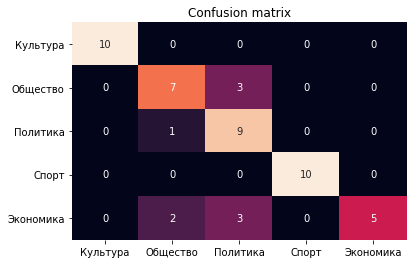

In [11]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_true, y_pred))
labels = test_corpus.topic.unique()
y_true = le.inverse_transform(y_true)
y_pred = le.inverse_transform(y_pred)
sns.heatmap(data=confusion_matrix(y_true, y_pred, labels = labels), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [12]:
sequences = tokenizer.texts_to_sequences(train_corpus.body)
X_train = pad_sequences(sequences, maxlen=TEXT_LENGTH)
sequences = tokenizer.texts_to_sequences(test_corpus.body)
X_test = pad_sequences(sequences, maxlen=TEXT_LENGTH)

In [13]:
X_train[0]

array([   0,    0,    0, ..., 1275, 2034, 1517], dtype=int32)

In [15]:
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIM, input_length=TEXT_LENGTH))
model.add(Flatten())
model.add(Dense(128, input_shape=(MAX_FEATURES,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,  validation_split=0.1)

Train on 450 samples, validate on 50 samples
Epoch 1/1000
450/450 [==============================] - 1s 3ms/step - loss: 2.6975 - acc: 0.2156 - val_loss: 2.0813 - val_acc: 0.0000e+00
Epoch 2/1000
450/450 [==============================] - 1s 1ms/step - loss: 1.5113 - acc: 0.4244 - val_loss: 2.7515 - val_acc: 0.0000e+00
Epoch 3/1000
450/450 [==============================] - 1s 1ms/step - loss: 1.3578 - acc: 0.4556 - val_loss: 2.3738 - val_acc: 0.0000e+00
Epoch 4/1000
450/450 [==============================] - 1s 1ms/step - loss: 1.1195 - acc: 0.6244 - val_loss: 2.2049 - val_acc: 0.0000e+00
Epoch 5/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.8387 - acc: 0.7889 - val_loss: 1.6807 - val_acc: 0.0400
Epoch 6/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.5825 - acc: 0.8933 - val_loss: 2.2124 - val_acc: 0.0000e+00
Epoch 7/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.4004 - acc: 0.9400 - val_loss: 2.1431 - val_acc: 0.00

450/450 [==============================] - 1s 1ms/step - loss: 0.0065 - acc: 0.9978 - val_loss: 2.5442 - val_acc: 0.1200
Epoch 62/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 1.8966 - val_acc: 0.2800
Epoch 63/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 1.7991 - val_acc: 0.3000
Epoch 64/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 2.0232 - val_acc: 0.2400
Epoch 65/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 2.3722 - val_acc: 0.1400
Epoch 66/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 2.6821 - val_acc: 0.0800
Epoch 67/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 2.5293 - val_acc: 0.1000
Epoch 68/1000
450/450 [==============================] - 1s 1ms/step 

Epoch 121/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 2.3285 - val_acc: 0.2000
Epoch 122/1000
450/450 [==============================] - 1s 1ms/step - loss: 4.4433e-04 - acc: 1.0000 - val_loss: 2.3111 - val_acc: 0.2000
Epoch 123/1000
450/450 [==============================] - 1s 1ms/step - loss: 4.5624e-04 - acc: 1.0000 - val_loss: 2.4232 - val_acc: 0.2000
Epoch 124/1000
450/450 [==============================] - 1s 1ms/step - loss: 7.4538e-04 - acc: 1.0000 - val_loss: 2.5021 - val_acc: 0.1600
Epoch 125/1000
450/450 [==============================] - 1s 1ms/step - loss: 4.9799e-04 - acc: 1.0000 - val_loss: 2.6750 - val_acc: 0.1600
Epoch 126/1000
450/450 [==============================] - 1s 1ms/step - loss: 6.6015e-04 - acc: 1.0000 - val_loss: 2.7970 - val_acc: 0.1400
Epoch 127/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 2.9374 - val_acc: 0.1200
Epoch 128/1000
450/450 [====

450/450 [==============================] - 1s 1ms/step - loss: 1.8125e-04 - acc: 1.0000 - val_loss: 2.2515 - val_acc: 0.2800
Epoch 181/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 2.1199 - val_acc: 0.3400
Epoch 182/1000
450/450 [==============================] - 1s 1ms/step - loss: 6.0248e-04 - acc: 1.0000 - val_loss: 2.3211 - val_acc: 0.2800
Epoch 183/1000
450/450 [==============================] - 1s 1ms/step - loss: 9.4260e-04 - acc: 1.0000 - val_loss: 2.2198 - val_acc: 0.3200
Epoch 184/1000
450/450 [==============================] - 1s 1ms/step - loss: 2.9253e-04 - acc: 1.0000 - val_loss: 2.0902 - val_acc: 0.3400
Epoch 185/1000
450/450 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 2.3502 - val_acc: 0.3200
Epoch 186/1000
450/450 [==============================] - 1s 1ms/step - loss: 6.6935e-04 - acc: 1.0000 - val_loss: 3.2223 - val_acc: 0.1200
Epoch 187/1000
450/450 [===================

KeyboardInterrupt: 

In [16]:
y_pred = model.predict_classes(X_test)
y_pred = le.inverse_transform(y_pred)

/home/ec/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

   Культура       0.82      0.90      0.86        10
   Общество       0.80      0.40      0.53        10
   Политика       0.45      0.90      0.60        10
      Спорт       0.91      1.00      0.95        10
  Экономика       1.00      0.30      0.46        10

avg / total       0.80      0.70      0.68        50



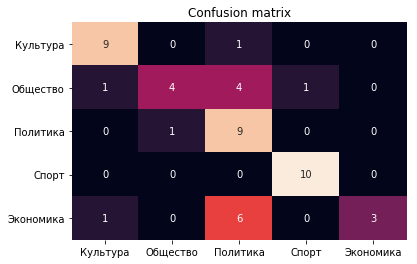

In [17]:
print(classification_report(y_true, y_pred))
sns.heatmap(data=confusion_matrix(y_true, y_pred, labels = labels), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [26]:
%%time

import numpy as np
emb_path = '/home/ec/aemelianov/nlp-mipt/hw3/ru.vec'

words = []

embeddings_index = {}
f = open(emb_path)
for line in f:
    values = line.split()
    if len(values) == 301:
        word = values[0]
        words.append(word)
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

CPU times: user 4.06 s, sys: 88 ms, total: 4.15 s
Wall time: 4.11 s


In [27]:
print(len(embeddings_index))

50103


In [28]:
word_index = tokenizer.word_index
len(word_index)

14823

In [30]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [32]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=TEXT_LENGTH,
                            trainable=False))
model.add(Flatten())
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 [==============================] - 0s 702us/step - loss: 1.2581 - acc: 0.5556 - val_loss: 0.9239 - val_acc: 0.5800
Epoch 2/10
450/450 [==============================] - 0s 211us/step - loss: 0.1527 - acc: 0.9733 - val_loss: 2.2076 - val_acc: 0.3200
Epoch 3/10
450/450 [==============================] - 0s 209us/step - loss: 0.0334 - acc: 1.0000 - val_loss: 3.6835 - val_acc: 0.1200
Epoch 4/10
450/450 [==============================] - 0s 208us/step - loss: 0.0142 - acc: 1.0000 - val_loss: 3.3971 - val_acc: 0.1800
Epoch 5/10
450/450 [==============================] - 0s 207us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 3.1034 - val_acc: 0.2200
Epoch 6/10
450/450 [==============================] - 0s 213us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 3.0325 - val_acc: 0.2200
Epoch 7/10
450/450 [==============================] - 0s 217us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 3.0162 - val_acc: 0.2400
Epoch 8/10
450/45

In [33]:
y_pred = model.predict_classes(X_test)
y_pred = le.inverse_transform(y_pred)

/home/ec/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

   Культура       0.89      0.80      0.84        10
   Общество       0.50      0.60      0.55        10
   Политика       0.53      0.90      0.67        10
      Спорт       0.91      1.00      0.95        10
  Экономика       1.00      0.10      0.18        10

avg / total       0.77      0.68      0.64        50



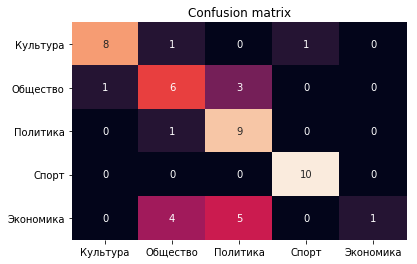

In [34]:
print(classification_report(y_true, y_pred))
sns.heatmap(data=confusion_matrix(y_true, y_pred, labels = labels), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

## Сверточные нейронные сети [Convolutional neural networks, CNN]

* Заимствованы из области компьютерного зрения
* Пик популярности пришелся на 2014 (до +10% аккуратности в задачах классификации), со временем были вытеснены рекуррентными нейронными сетями 
* Помогают справится  с проблемой переменной длины входов (CNN VS window-based NN)

In [38]:
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE,
                            300,
                            input_length=TEXT_LENGTH,
                            trainable=True))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 [==============================] - 3s 7ms/step - loss: 1.6129 - acc: 0.2689 - val_loss: 2.2324 - val_acc: 0.0000e+00
Epoch 2/10
450/450 [==============================] - 1s 2ms/step - loss: 1.3041 - acc: 0.4933 - val_loss: 2.1466 - val_acc: 0.0000e+00
Epoch 3/10
450/450 [==============================] - 1s 2ms/step - loss: 0.9401 - acc: 0.6511 - val_loss: 2.3902 - val_acc: 0.0000e+00
Epoch 4/10
450/450 [==============================] - 1s 2ms/step - loss: 0.5308 - acc: 0.9200 - val_loss: 1.1018 - val_acc: 0.5600
Epoch 5/10
450/450 [==============================] - 1s 2ms/step - loss: 0.2178 - acc: 0.9533 - val_loss: 1.7264 - val_acc: 0.2000
Epoch 6/10
450/450 [==============================] - 1s 2ms/step - loss: 0.0650 - acc: 0.9933 - val_loss: 1.1686 - val_acc: 0.6400
Epoch 7/10
450/450 [==============================] - 1s 2ms/step - loss: 0.0184 - acc: 1.0000 - val_loss: 1.9198 - val_acc: 0.3600
Epoch 8/10
450/450 

In [39]:
y_pred = model.predict_classes(X_test)
y_pred = le.inverse_transform(y_pred)

/home/ec/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [42]:
model.evaluate(X_test, y_test)

50/50 [==============================] - 0s 355us/step


[1.021263918876648, 0.7200000071525574]

             precision    recall  f1-score   support

   Культура       0.69      0.90      0.78        10
   Общество       0.71      0.50      0.59        10
   Политика       0.57      0.80      0.67        10
      Спорт       1.00      1.00      1.00        10
  Экономика       0.67      0.40      0.50        10

avg / total       0.73      0.72      0.71        50



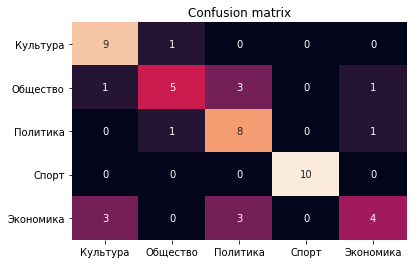

In [40]:
print(classification_report(y_true, y_pred))
sns.heatmap(data=confusion_matrix(y_true, y_pred, labels = labels), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()